In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/ailab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-01-13 12:45:14.959425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 12:45:14.963137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 12:45:14.963231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 12:45:14.963492: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

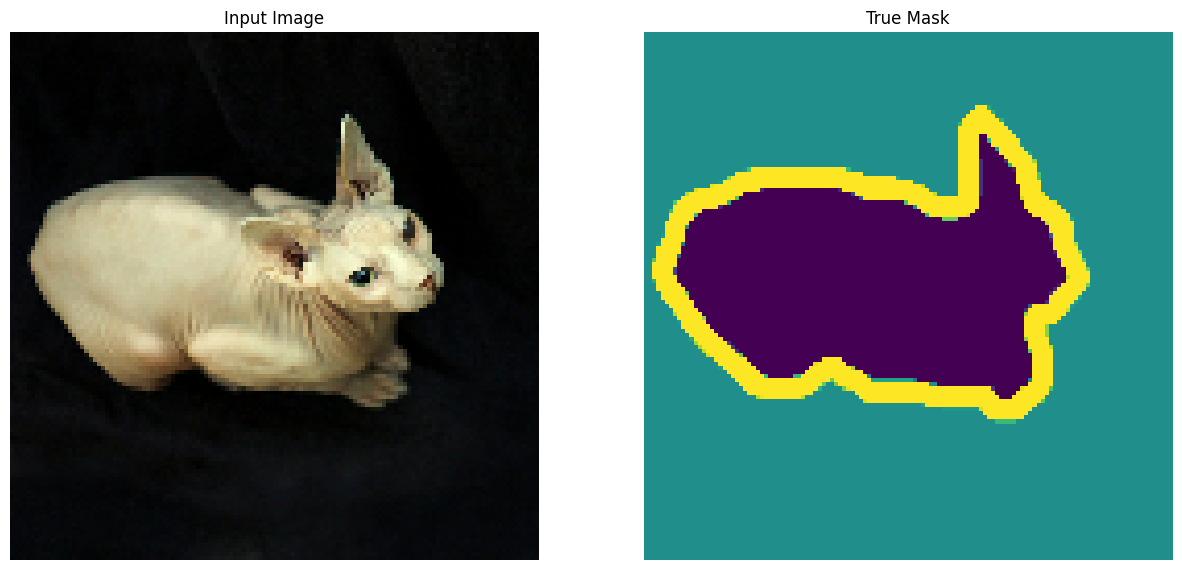

In [6]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [7]:
inputs = tf.keras.layers.Input(shape=[128, 128, 3])    
x = inputs  

# block 1
x = tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre1 = x

# block 2
x = tf.keras.layers.Conv2D(128, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre2 = x

# block 3
x = tf.keras.layers.Conv2D(256, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre3 = x

# block 4
x = tf.keras.layers.Conv2D(512, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre4 = x

# block 5
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# upsampling
x = tf.keras.layers.Conv2DTranspose(512, 3, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre4])

# upsampling
x = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre3])

# upsampling
x = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre2])

# upsampling
x = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre1])

# upsampling
x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same')(x)

model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

__________________________________________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-01-13 12:45:33.244110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-13 12:45:33.707229: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 12:45:33.707648: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 12:45:33.707661: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-13 12:45:33.708074: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 12:45:33.708116: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

919/920 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.7051

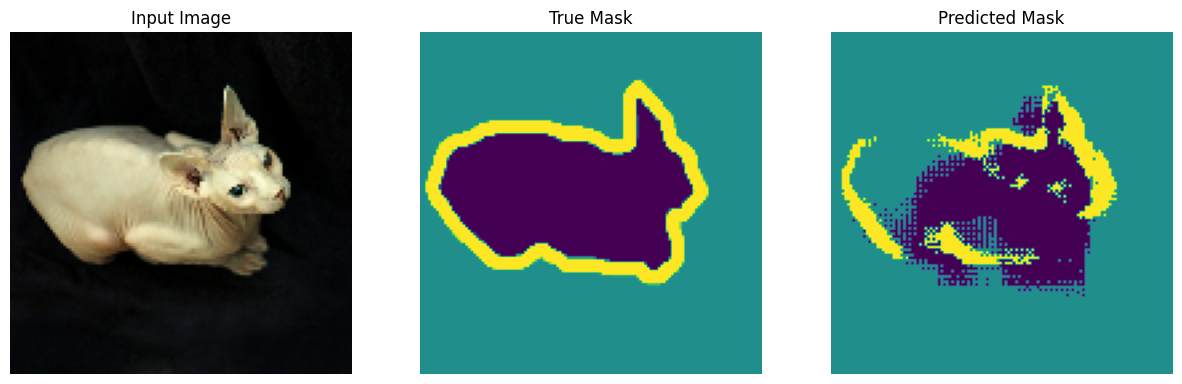


Sample Prediction after epoch 1

920/920 [==============================] - 21s 19ms/step - loss: 0.6866 - accuracy: 0.7050 - val_loss: 0.6096 - val_accuracy: 0.7458
Epoch 2/20
920/920 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7658

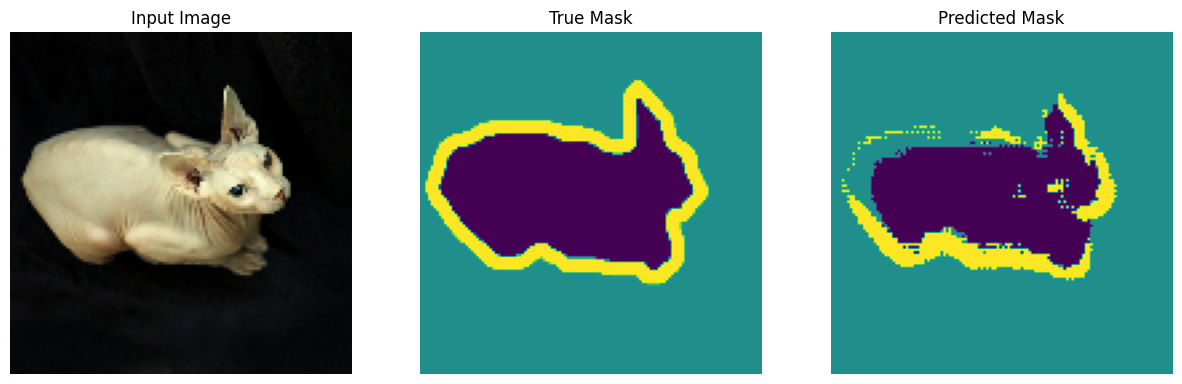


Sample Prediction after epoch 2

920/920 [==============================] - 17s 19ms/step - loss: 0.5672 - accuracy: 0.7658 - val_loss: 0.5628 - val_accuracy: 0.7666
Epoch 3/20
920/920 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7917

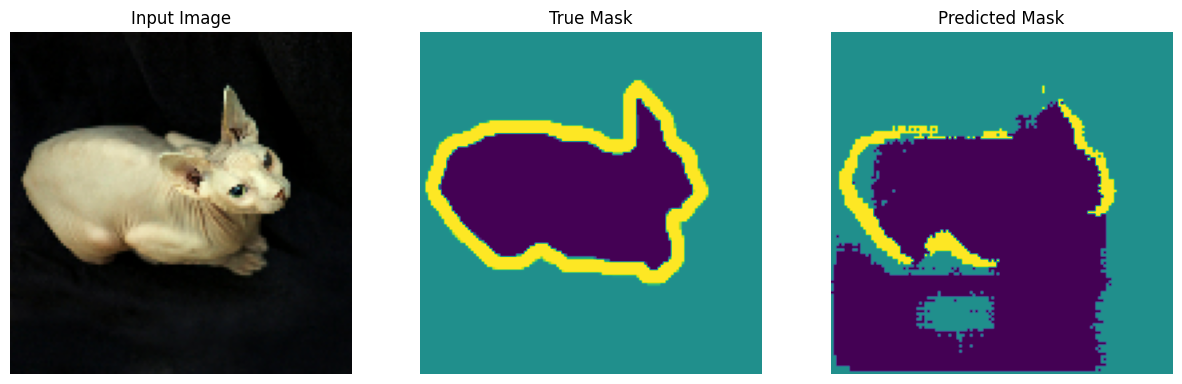


Sample Prediction after epoch 3

920/920 [==============================] - 17s 19ms/step - loss: 0.5065 - accuracy: 0.7917 - val_loss: 0.5423 - val_accuracy: 0.7820
Epoch 4/20
919/920 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8046

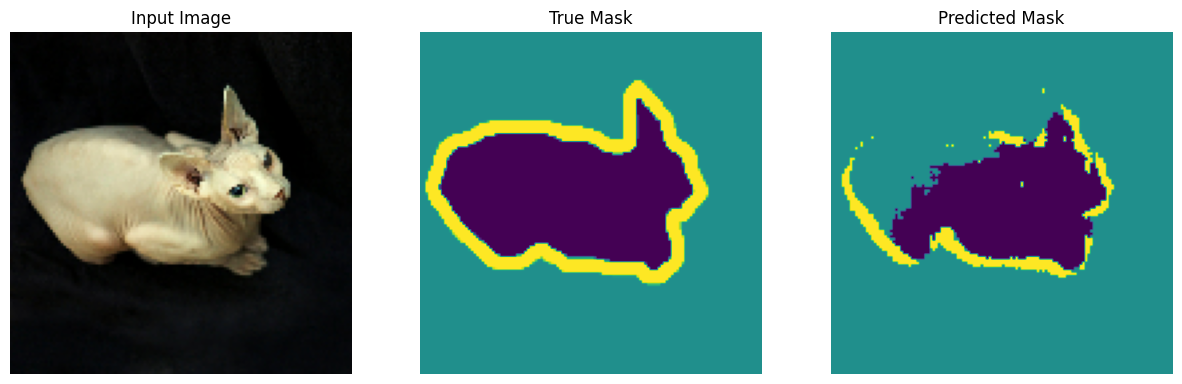


Sample Prediction after epoch 4

920/920 [==============================] - 17s 19ms/step - loss: 0.4786 - accuracy: 0.8045 - val_loss: 0.5889 - val_accuracy: 0.7643
Epoch 5/20
919/920 [============================>.] - ETA: 0s - loss: 0.4508 - accuracy: 0.8159

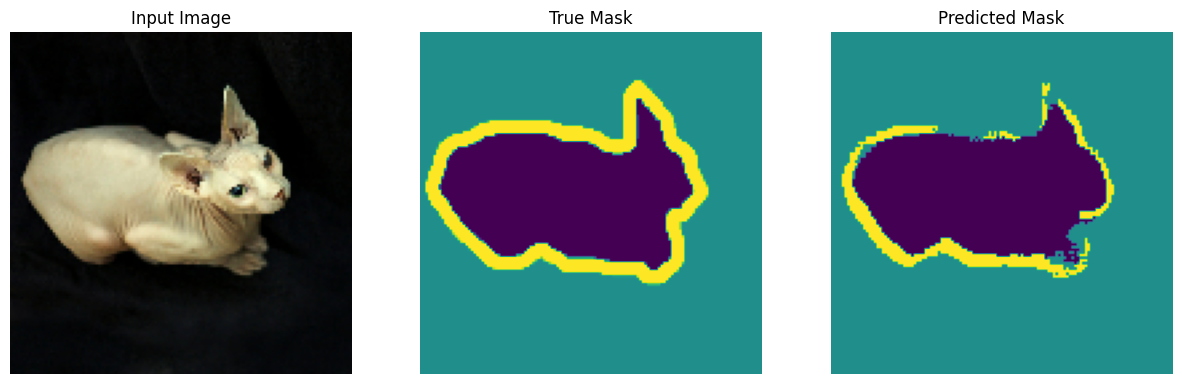


Sample Prediction after epoch 5

920/920 [==============================] - 17s 19ms/step - loss: 0.4509 - accuracy: 0.8159 - val_loss: 0.4898 - val_accuracy: 0.8011
Epoch 6/20
919/920 [============================>.] - ETA: 0s - loss: 0.4237 - accuracy: 0.8260

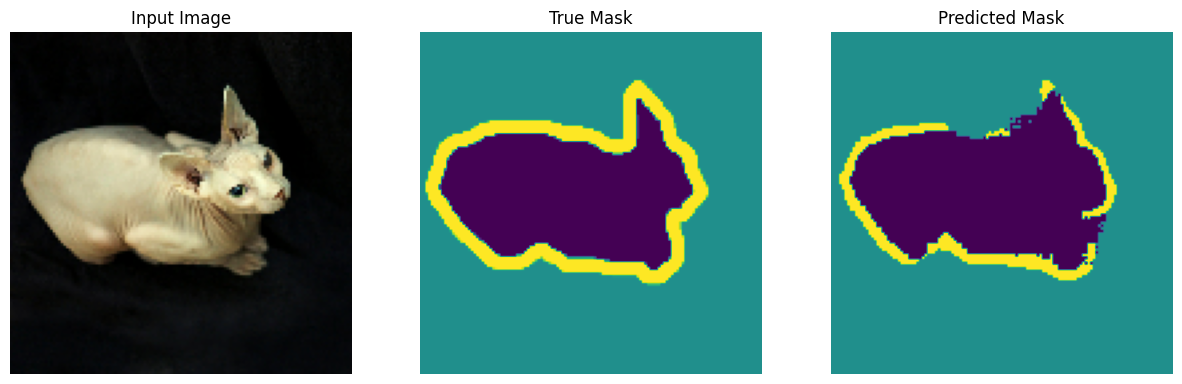


Sample Prediction after epoch 6

920/920 [==============================] - 17s 19ms/step - loss: 0.4236 - accuracy: 0.8260 - val_loss: 0.4517 - val_accuracy: 0.8186
Epoch 7/20
919/920 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8374

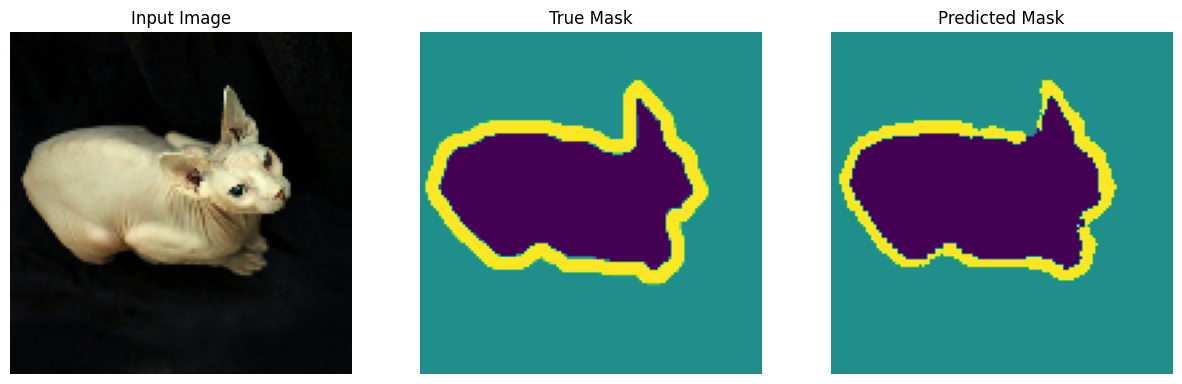


Sample Prediction after epoch 7

920/920 [==============================] - 17s 19ms/step - loss: 0.3962 - accuracy: 0.8374 - val_loss: 0.4566 - val_accuracy: 0.8128
Epoch 8/20
919/920 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.8478

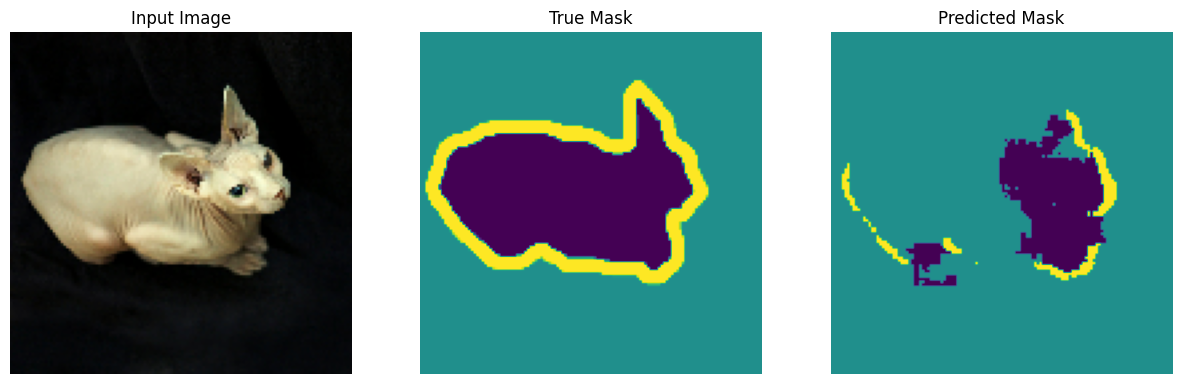


Sample Prediction after epoch 8

920/920 [==============================] - 17s 19ms/step - loss: 0.3698 - accuracy: 0.8479 - val_loss: 0.5832 - val_accuracy: 0.7724
Epoch 9/20
919/920 [============================>.] - ETA: 0s - loss: 0.3311 - accuracy: 0.8625

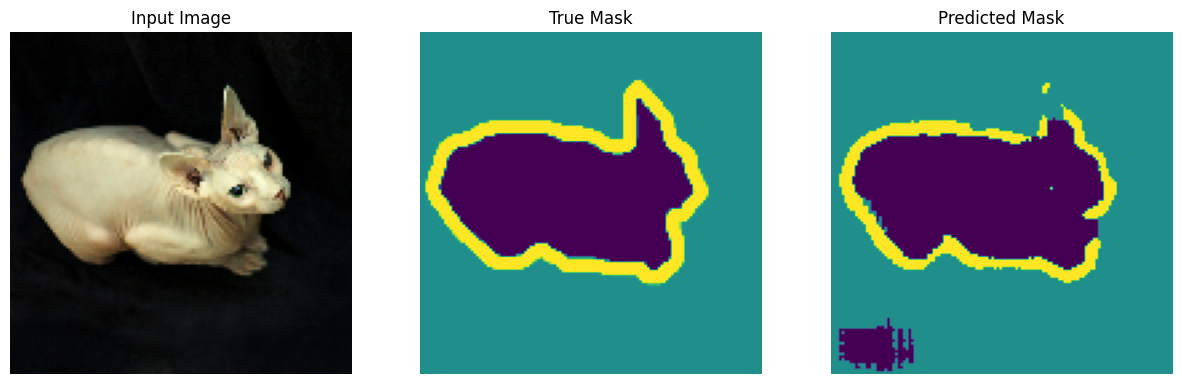


Sample Prediction after epoch 9

920/920 [==============================] - 17s 19ms/step - loss: 0.3310 - accuracy: 0.8625 - val_loss: 0.4224 - val_accuracy: 0.8295
Epoch 10/20
919/920 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8751

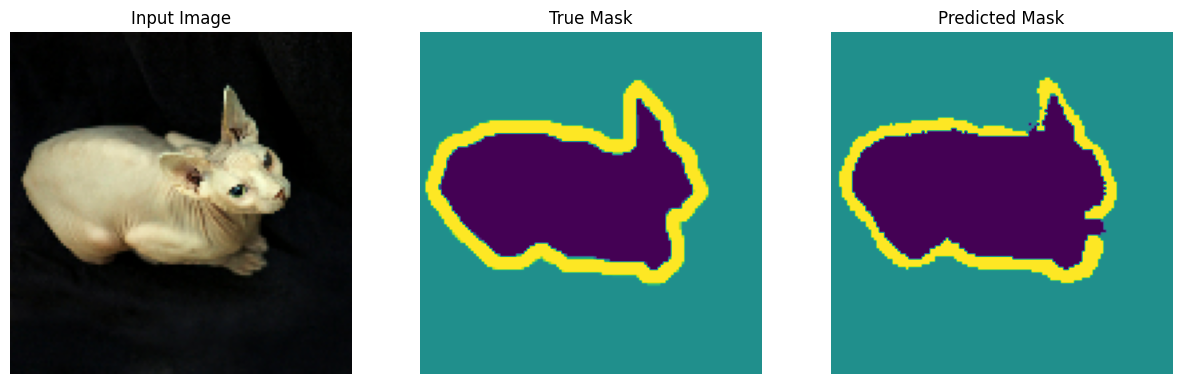


Sample Prediction after epoch 10

920/920 [==============================] - 17s 19ms/step - loss: 0.2991 - accuracy: 0.8751 - val_loss: 0.4626 - val_accuracy: 0.8210
Epoch 11/20
918/920 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8867

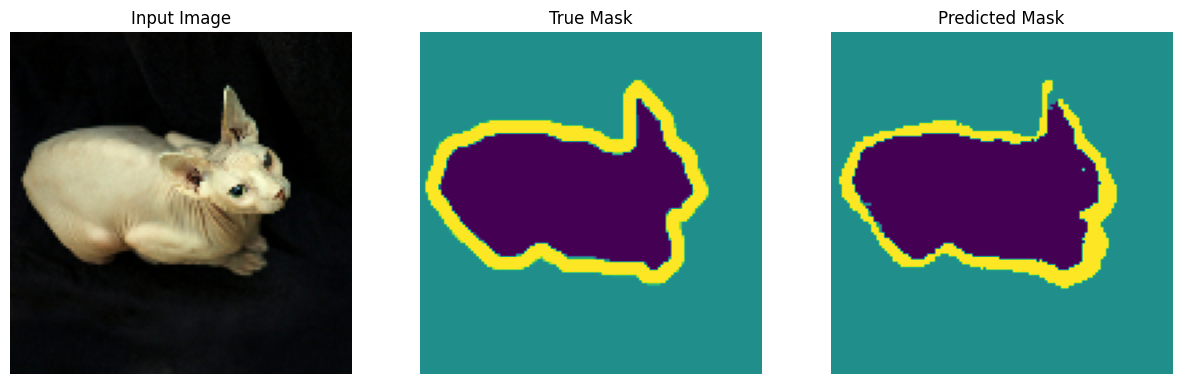


Sample Prediction after epoch 11

920/920 [==============================] - 17s 19ms/step - loss: 0.2685 - accuracy: 0.8866 - val_loss: 0.4694 - val_accuracy: 0.8276
Epoch 12/20
918/920 [============================>.] - ETA: 0s - loss: 0.2467 - accuracy: 0.8948

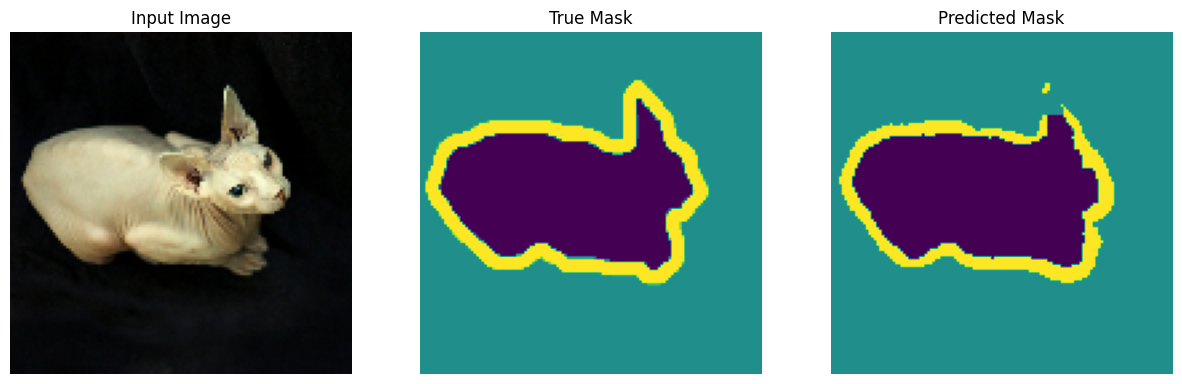


Sample Prediction after epoch 12

920/920 [==============================] - 18s 19ms/step - loss: 0.2469 - accuracy: 0.8947 - val_loss: 0.4544 - val_accuracy: 0.8354
Epoch 13/20
919/920 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9022

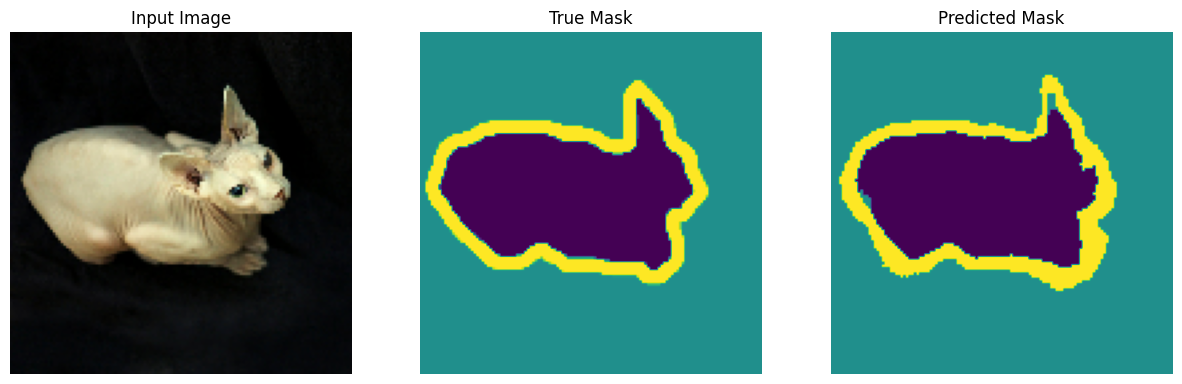


Sample Prediction after epoch 13

920/920 [==============================] - 17s 19ms/step - loss: 0.2262 - accuracy: 0.9022 - val_loss: 0.5022 - val_accuracy: 0.8222
Epoch 14/20
918/920 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9083

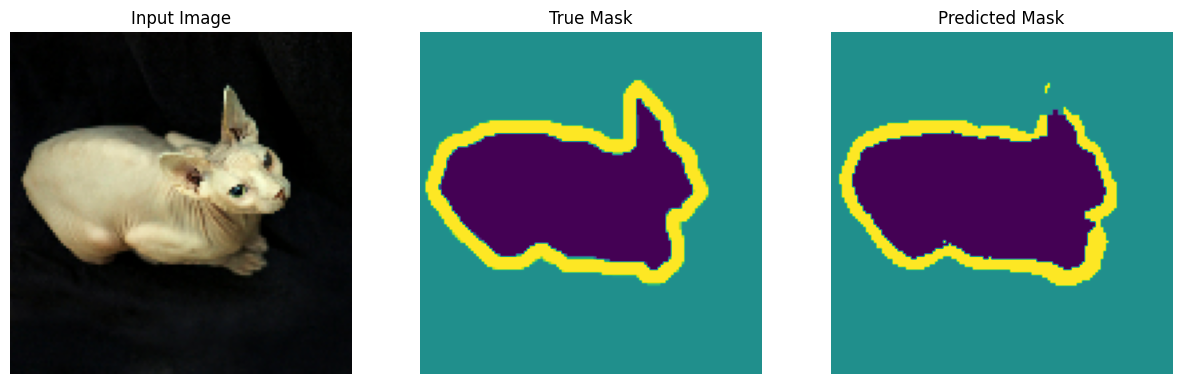


Sample Prediction after epoch 14

920/920 [==============================] - 17s 19ms/step - loss: 0.2106 - accuracy: 0.9082 - val_loss: 0.4886 - val_accuracy: 0.8305
Epoch 15/20
918/920 [============================>.] - ETA: 0s - loss: 0.2005 - accuracy: 0.9121

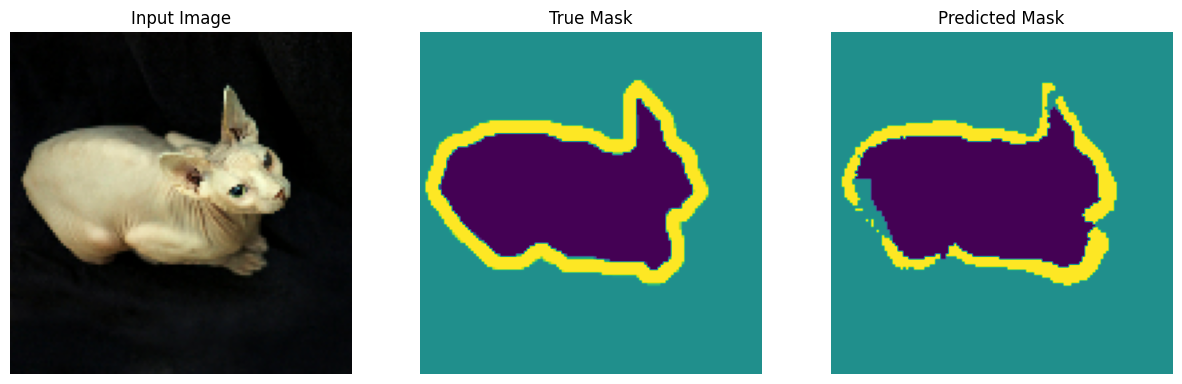


Sample Prediction after epoch 15

920/920 [==============================] - 17s 19ms/step - loss: 0.2005 - accuracy: 0.9121 - val_loss: 0.4955 - val_accuracy: 0.8349
Epoch 16/20
919/920 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9189

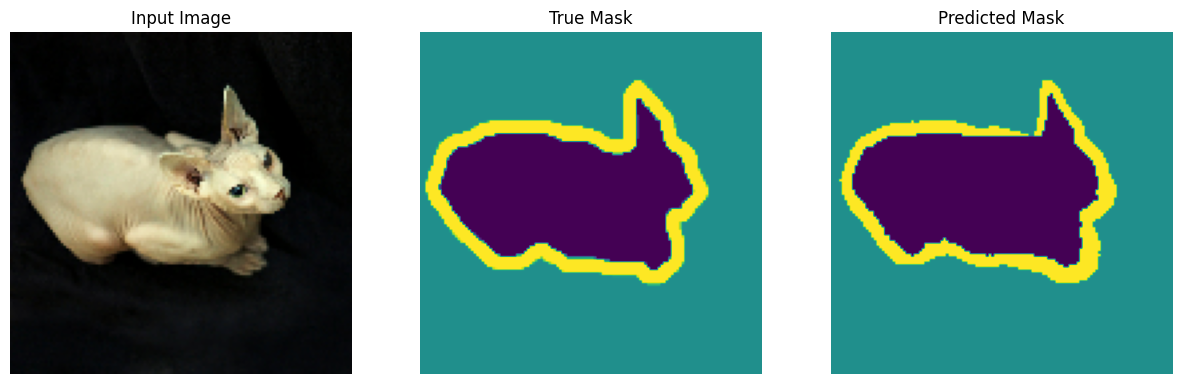


Sample Prediction after epoch 16

920/920 [==============================] - 17s 19ms/step - loss: 0.1827 - accuracy: 0.9189 - val_loss: 0.5064 - val_accuracy: 0.8337
Epoch 17/20
918/920 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9230

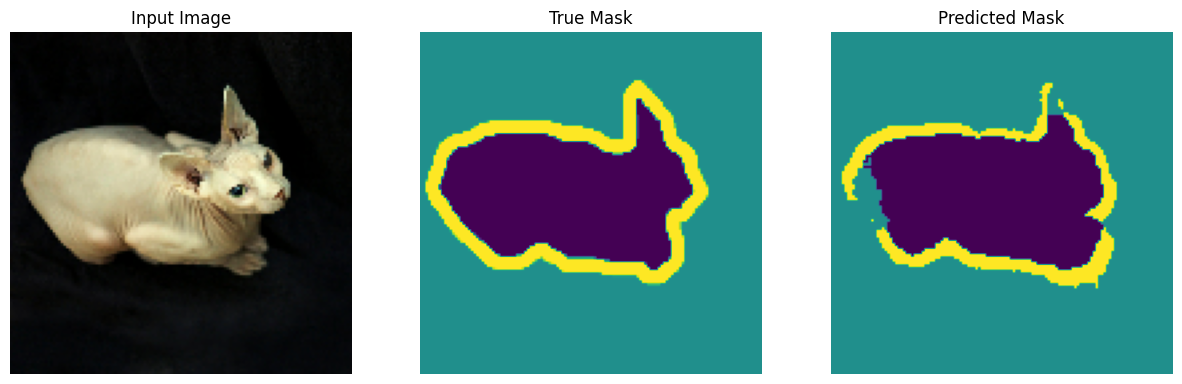


Sample Prediction after epoch 17

920/920 [==============================] - 17s 19ms/step - loss: 0.1721 - accuracy: 0.9230 - val_loss: 0.6487 - val_accuracy: 0.8097
Epoch 18/20
919/920 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9250

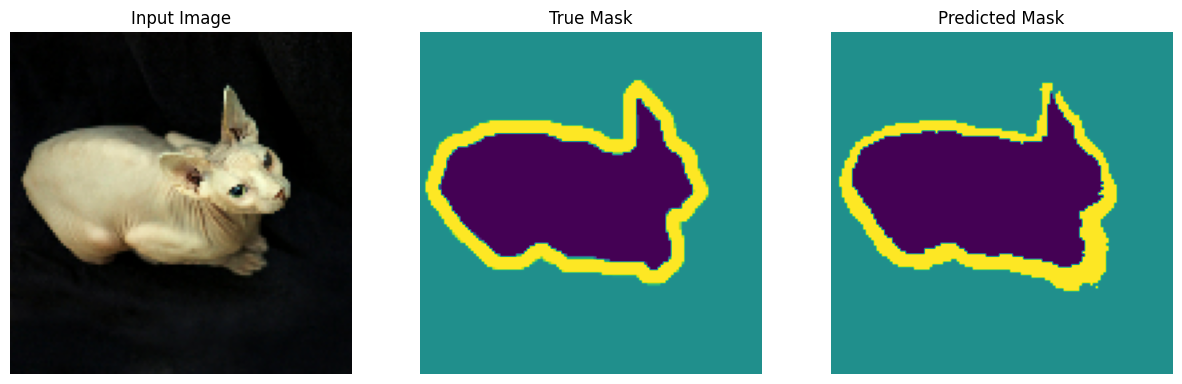


Sample Prediction after epoch 18

920/920 [==============================] - 17s 19ms/step - loss: 0.1675 - accuracy: 0.9250 - val_loss: 0.5153 - val_accuracy: 0.8305
Epoch 19/20
919/920 [============================>.] - ETA: 0s - loss: 0.1606 - accuracy: 0.9277

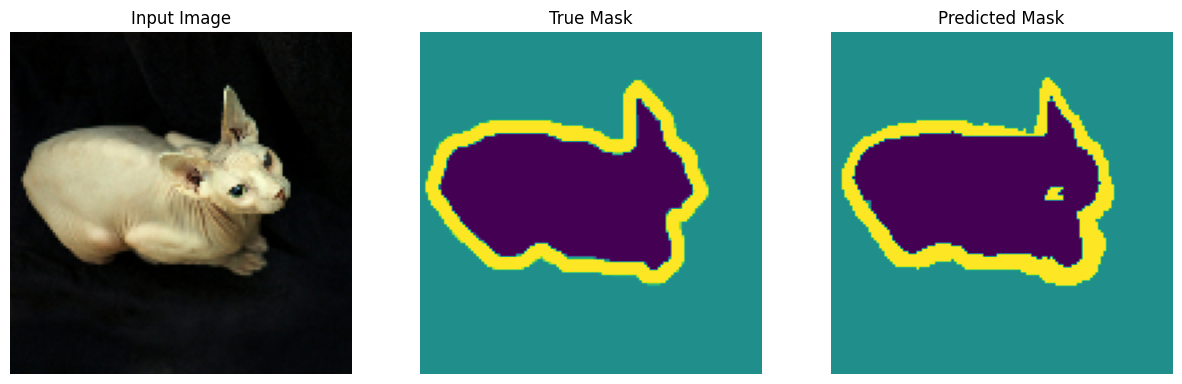


Sample Prediction after epoch 19

920/920 [==============================] - 17s 19ms/step - loss: 0.1606 - accuracy: 0.9277 - val_loss: 0.5479 - val_accuracy: 0.8319
Epoch 20/20
919/920 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9322

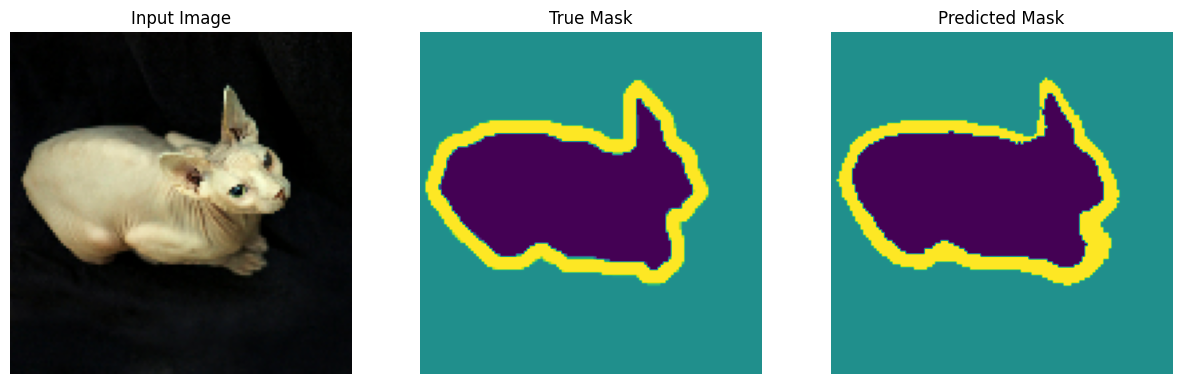


Sample Prediction after epoch 20

920/920 [==============================] - 17s 19ms/step - loss: 0.1500 - accuracy: 0.9322 - val_loss: 0.5625 - val_accuracy: 0.8369


In [9]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

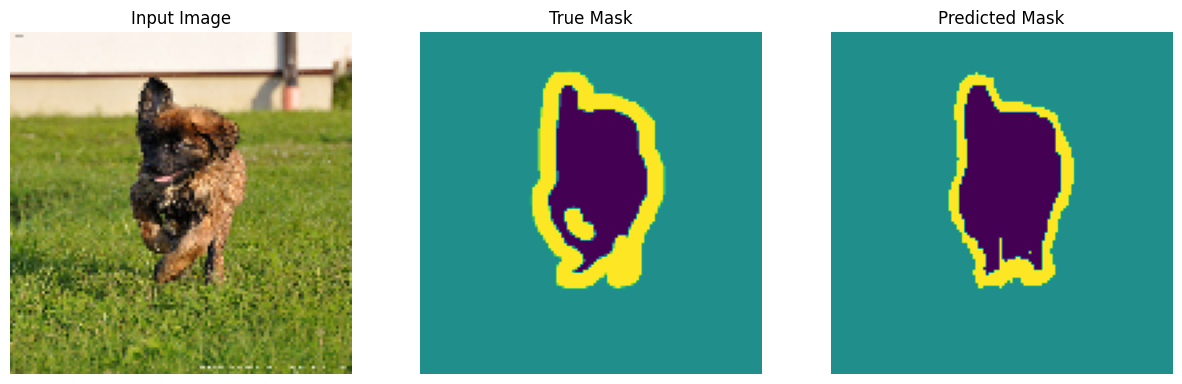

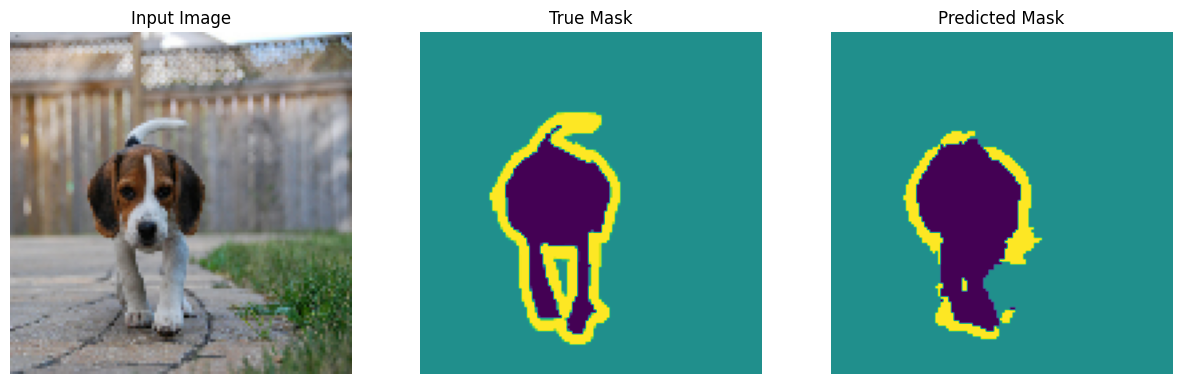

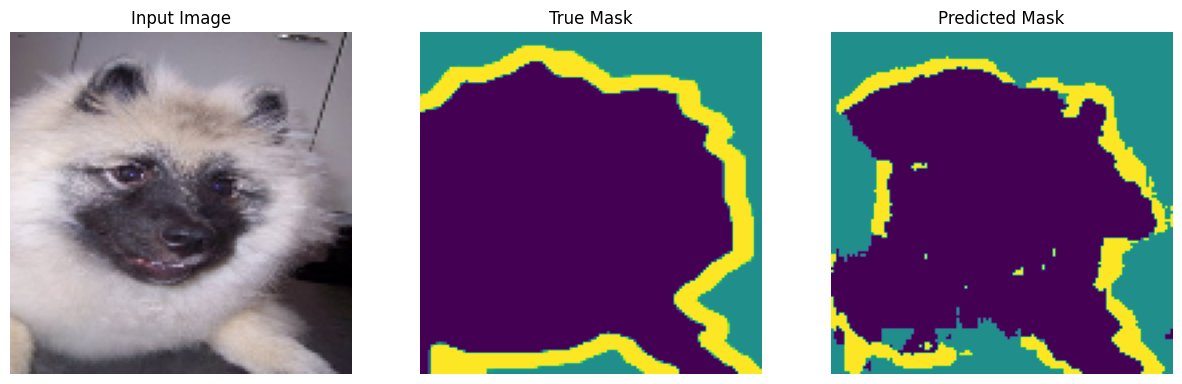

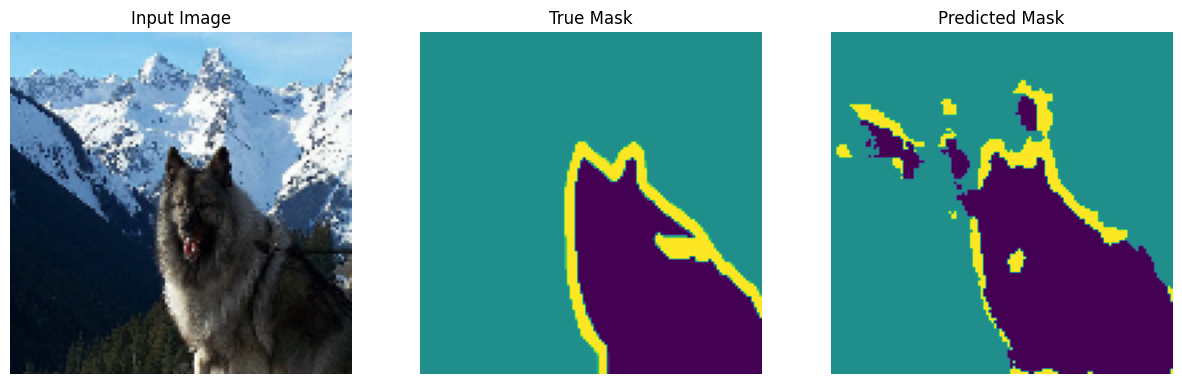

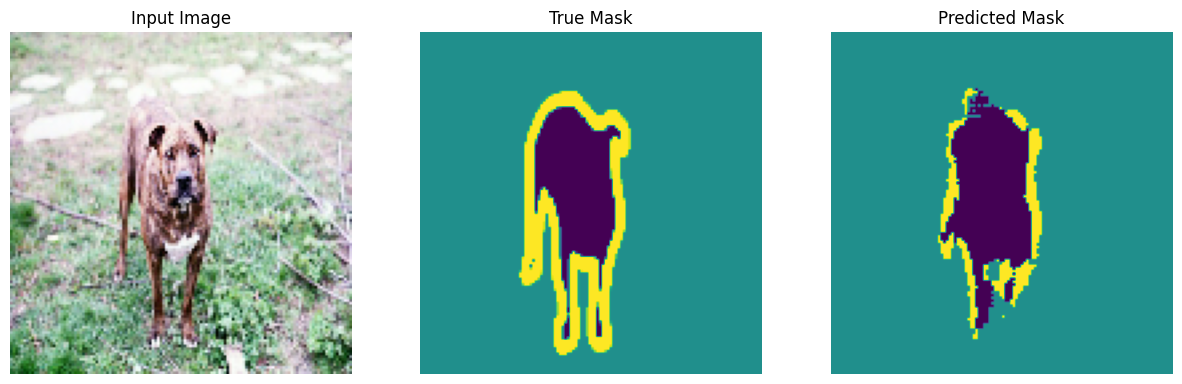

In [10]:
show_predictions(test_dataset, 5)